# Master MVA- Generative Modeling
### Assignment 25th Feb
### Benjamin Deporte

### Import librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
torch.set_default_dtype(torch.float64)

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

!nvidia-smi

# set seeds for reproductibility
random_seed = 42
rng = np.random.default_rng(seed=random_seed)
torch.manual_seed(random_seed)

cpu
/bin/bash: line 1: nvidia-smi: command not found


# 2D-Data

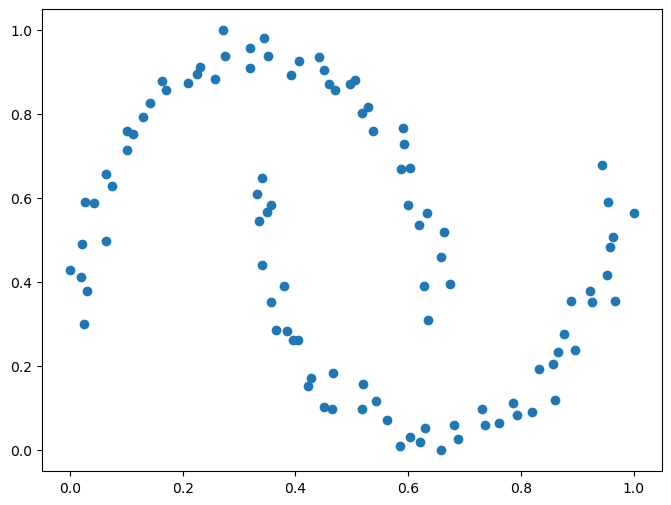

In [3]:
# we will use the two moons dataset here

from sklearn.datasets import make_moons

# parameters
N_SAMPLES = 100
NOISE = 0.05

# generate data
X, _ = make_moons(n_samples=N_SAMPLES, noise=NOISE, random_state=random_seed)

# force into [0,1]^2
X[:,0] = (X[:,0] - np.min(X[:,0])) / (np.max(X[:,0]) - np.min(X[:,0]))
X[:,1] = (X[:,1] - np.min(X[:,1])) / (np.max(X[:,1]) - np.min(X[:,1]))

# format into tensor
X_data = torch.tensor(X)

# plot dataset
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_data.detach().cpu().numpy()[:,0], X_data.detach().cpu().numpy()[:,1])

plt.show()

### GAN Training

In [4]:
# Generator - we reuse the code from TP

class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=device):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        # create nlayers of nn.Linear of size
        # - n_in for the first one
        # - n_hid for the others
        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        # otuput layer, n_out neurons then Sigmoid
        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()

In [5]:
n_in = 10    # input dimension, dimension of the original Gaussian
d = 2        # dimension of data points

b = 100      # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)
z = torch.randn(b, n_in, device=device)
X_gen = G(z).detach().cpu().numpy()

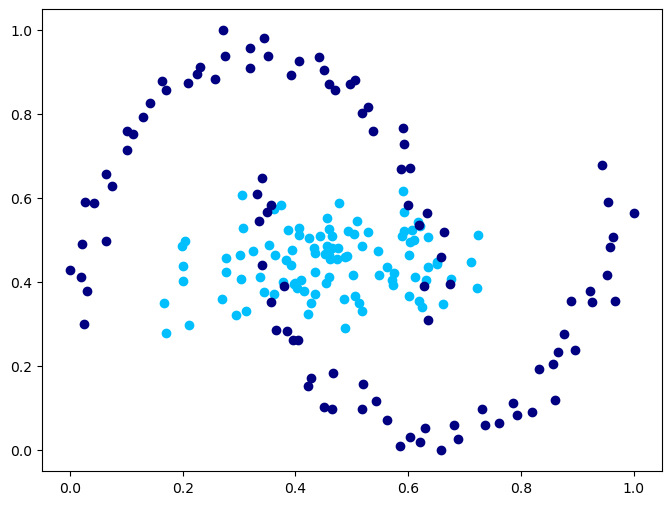

In [6]:
# Sampling test

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(X_gen[:,0], X_gen[:,1], c='deepskyblue')
ax.scatter(X_data[:,0], X_data[:,1], c='navy')
plt.show()

In [7]:
# Discriminator - we reuse the code from TP

class DiscriminatorGAN(nn.Module):
  def __init__(self, n_in=2, n_hid=10, device=device):
    super(DiscriminatorGAN, self).__init__()

    # n_in is the input dimension, 2 here as data points are 2D
    self.n_hid = n_hid
    self.n_in = n_in    

    self.fc1 = nn.Linear(n_in, n_hid).to(device)
    self.fc2 = nn.Linear(n_hid, n_hid).to(device)
    self.fc3 = nn.Linear(n_hid, 1).to(device)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    # output probability of the input X being a real data point
    y = nn.Sigmoid()(self.fc3(y))
    return y

### GAN Training Loop

In [11]:
def train_GAN(
  GenFreeze=False,
  niterD=100,
  niterG=1,
  lrdisc=1e-2,
  lrgen=1e-3,
  iter_display=10
  ):
  
  # Report out
  print(f"Training GAN - GenFreeze={GenFreeze}")
  # Training loop

  # parameters
  lrgen = lrgen   # learning rate for generator
  lrdisc = lrdisc  # learning rate for discriminator
  n_epochs = 100
  niterD=niterD
  niterG=niterG

  # Initialize generator and discriminator
  G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)
  D = DiscriminatorGAN(n_in=d, n_hid=100, device=device)

  # get ready
  optimG = optim.Adam(G.parameters(), lr=lrgen)
  optimD = optim.Adam(D.parameters(), lr=lrdisc) #, betas=(beta_1, beta_2))

  # logs
  Glosses = []
  Dlosses = []

  # reporting 
  iter_display = iter_display

  # Main loop
  for epoch in range(1,n_epochs):

      ###########################################
      ### Train discriminator (niterD iterations)
      ###########################################
      
      #### ie max sur D de la loss
      for iter in range(0,niterD):
        optimD.zero_grad()
        X_gen = G(torch.randn(b, n_in, device=device))
        Dx = D(X_gen)
        # we want to maximize D(X_data) and minimize D(X_gen)
        # Dloss should be as small as possible
        Dloss = - (torch.mean(D(X_data)) - torch.mean(Dx))
        optimD.zero_grad()
        Dloss.backward()
        optimD.step()
        # GAN : no gradient cliping !
        # for p in D.parameters():
        #     p.data.clamp_(-clip_value, clip_value)

      ############################
      ### Train generator (niterG iterations)
      ############################
      ### ie min sur G de la loss
      for iter in range(0,niterG):
        # we want to maximize D(G(z))
        # Gloss should be as small as possible
        Gloss = - torch.mean(D(G(torch.randn(b, n_in, device=device))))
        if GenFreeze is not True:
          optimG.zero_grad()
          Gloss.backward()
          optimG.step()

      # Output training stats
      print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
        % (epoch, n_epochs, Dloss.item(), Gloss.item()))
      Glosses.append(Gloss.item())
      Dlosses.append(Dloss.item())

      # draw pictures from time to time
      if(epoch % iter_display == 0):
          fig, ax = plt.subplots(figsize=(4, 4))
          # plot data
          ax.scatter(X_data[:,0], X_data[:,1], c='navy')
          # plot generated points
          z = torch.randn(b, n_in, device=device)
          x_gen = G(z).detach().cpu().numpy()
          ax.scatter(x_gen[:,0], x_gen[:,1], c='deepskyblue')
          plt.show()

  ### Plot the evolution of the discriminator and generator losses ###
  plt.figure(dpi=100)
  plt.plot(Dlosses,label='D')
  plt.plot(Glosses,label='G')
  plt.title(f'Loss evolution - GenFreeze={GenFreeze}')
  plt.legend()
  plt.show()

### First, we fix the generator and make sure the discriminator train

Training GAN - GenFreeze=True
[1/100] 	Loss_D: -0.0209	Loss_G: -0.4727
[2/100] 	Loss_D: -0.0496	Loss_G: -0.4416
[3/100] 	Loss_D: -0.0888	Loss_G: -0.3851
[4/100] 	Loss_D: -0.1672	Loss_G: -0.3411
[5/100] 	Loss_D: -0.2405	Loss_G: -0.3171
[6/100] 	Loss_D: -0.3378	Loss_G: -0.2659
[7/100] 	Loss_D: -0.4574	Loss_G: -0.2170
[8/100] 	Loss_D: -0.5173	Loss_G: -0.1791
[9/100] 	Loss_D: -0.5602	Loss_G: -0.1496
[10/100] 	Loss_D: -0.6131	Loss_G: -0.1140
[11/100] 	Loss_D: -0.6498	Loss_G: -0.1049
[12/100] 	Loss_D: -0.6606	Loss_G: -0.0695
[13/100] 	Loss_D: -0.6825	Loss_G: -0.0776
[14/100] 	Loss_D: -0.6907	Loss_G: -0.0703
[15/100] 	Loss_D: -0.6727	Loss_G: -0.0743
[16/100] 	Loss_D: -0.7061	Loss_G: -0.0525
[17/100] 	Loss_D: -0.7133	Loss_G: -0.0614
[18/100] 	Loss_D: -0.7034	Loss_G: -0.0732
[19/100] 	Loss_D: -0.6991	Loss_G: -0.0521
[20/100] 	Loss_D: -0.7234	Loss_G: -0.0875
[21/100] 	Loss_D: -0.7322	Loss_G: -0.0383
[22/100] 	Loss_D: -0.7375	Loss_G: -0.0570
[23/100] 	Loss_D: -0.7058	Loss_G: -0.0534
[24/100] 	Los

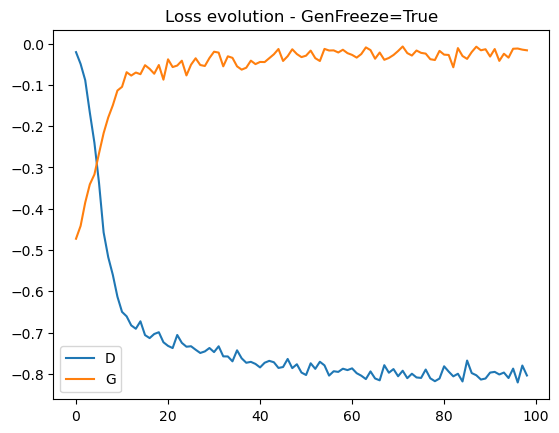

In [12]:
train_GAN(GenFreeze=True, lrdisc=1e-4, iter_display=200)

### Then, we train the Generator also, and give the Discriminator lots of epochs to train

Training GAN - GenFreeze=False
[1/100] 	Loss_D: -0.0302	Loss_G: -0.4428
[2/100] 	Loss_D: -0.1005	Loss_G: -0.3925
[3/100] 	Loss_D: -0.2106	Loss_G: -0.3430
[4/100] 	Loss_D: -0.3374	Loss_G: -0.2766
[5/100] 	Loss_D: -0.3807	Loss_G: -0.2025
[6/100] 	Loss_D: -0.3011	Loss_G: -0.1680
[7/100] 	Loss_D: -0.3258	Loss_G: -0.2573
[8/100] 	Loss_D: -0.3533	Loss_G: -0.2944
[9/100] 	Loss_D: -0.2227	Loss_G: -0.3497
[10/100] 	Loss_D: -0.1597	Loss_G: -0.4103


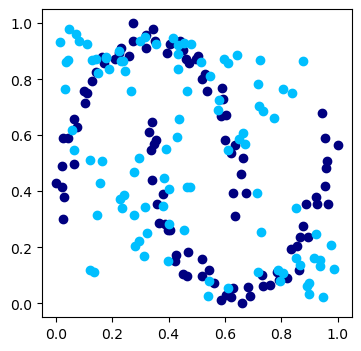

[11/100] 	Loss_D: -0.0886	Loss_G: -0.4761
[12/100] 	Loss_D: -0.0730	Loss_G: -0.4398
[13/100] 	Loss_D: -0.0486	Loss_G: -0.6065
[14/100] 	Loss_D: 0.0058	Loss_G: -0.7786
[15/100] 	Loss_D: -0.0036	Loss_G: -0.7728
[16/100] 	Loss_D: 0.0747	Loss_G: -0.7542
[17/100] 	Loss_D: 0.0018	Loss_G: -0.9928
[18/100] 	Loss_D: 0.0005	Loss_G: -0.9984
[19/100] 	Loss_D: 0.0003	Loss_G: -0.9993
[20/100] 	Loss_D: 0.0002	Loss_G: -0.9998


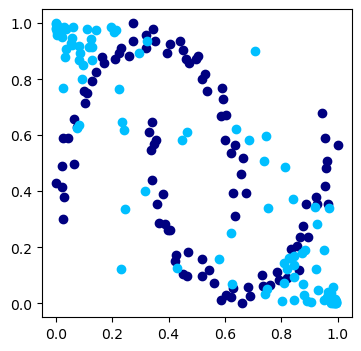

[21/100] 	Loss_D: 0.0001	Loss_G: -0.9999
[22/100] 	Loss_D: 0.0001	Loss_G: -0.9999
[23/100] 	Loss_D: 0.0001	Loss_G: -0.9999
[24/100] 	Loss_D: 0.0001	Loss_G: -0.9999
[25/100] 	Loss_D: 0.0001	Loss_G: -1.0000
[26/100] 	Loss_D: 0.0001	Loss_G: -1.0000
[27/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[28/100] 	Loss_D: 0.0001	Loss_G: -1.0000
[29/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[30/100] 	Loss_D: 0.0000	Loss_G: -1.0000


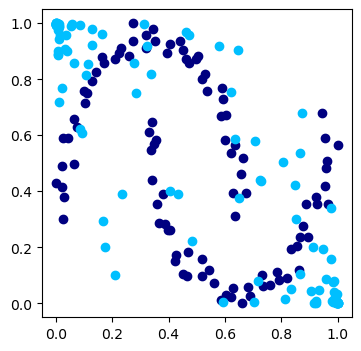

[31/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[32/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[33/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[34/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[35/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[36/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[37/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[38/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[39/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[40/100] 	Loss_D: 0.0000	Loss_G: -1.0000


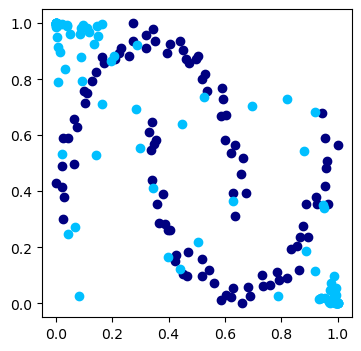

[41/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[42/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[43/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[44/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[45/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[46/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[47/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[48/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[49/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[50/100] 	Loss_D: 0.0000	Loss_G: -1.0000


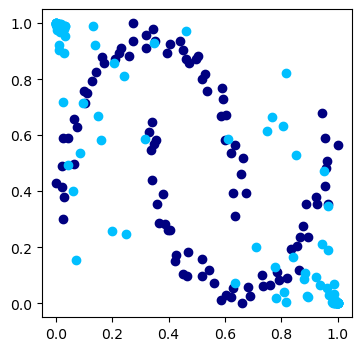

[51/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[52/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[53/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[54/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[55/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[56/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[57/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[58/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[59/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[60/100] 	Loss_D: 0.0000	Loss_G: -1.0000


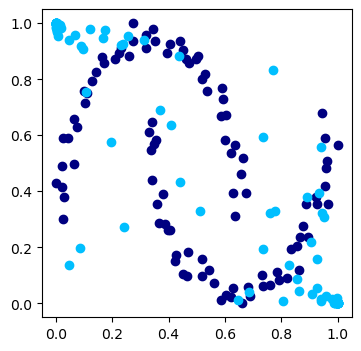

[61/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[62/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[63/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[64/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[65/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[66/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[67/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[68/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[69/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[70/100] 	Loss_D: 0.0000	Loss_G: -1.0000


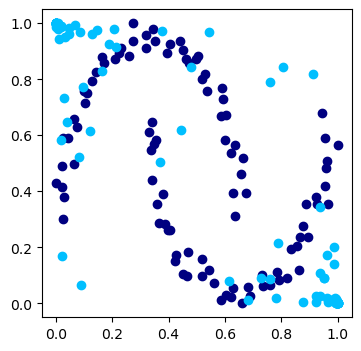

[71/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[72/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[73/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[74/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[75/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[76/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[77/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[78/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[79/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[80/100] 	Loss_D: 0.0000	Loss_G: -1.0000


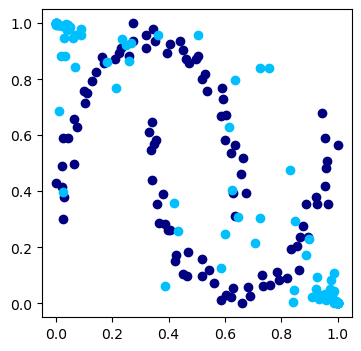

[81/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[82/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[83/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[84/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[85/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[86/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[87/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[88/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[89/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[90/100] 	Loss_D: 0.0000	Loss_G: -1.0000


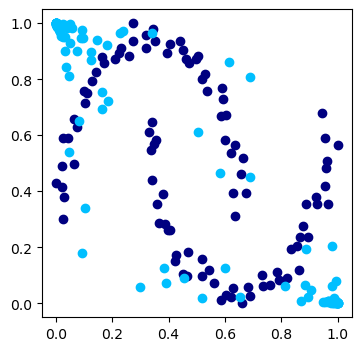

[91/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[92/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[93/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[94/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[95/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[96/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[97/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[98/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[99/100] 	Loss_D: 0.0000	Loss_G: -1.0000


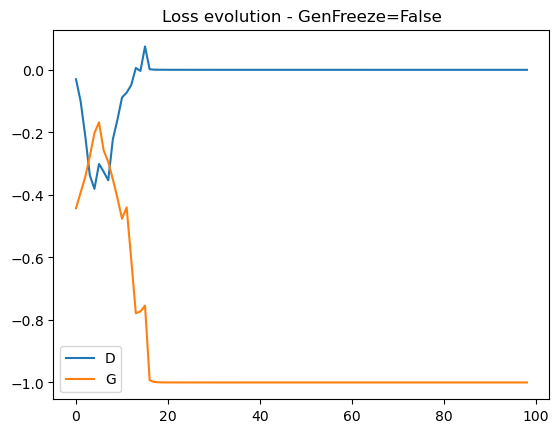

In [13]:
train_GAN(GenFreeze=False, niterD=200, lrdisc=1e-4, iter_display=10)

# Q1.a Comment on the differences with respect to the WGAN learning algorithm.

The vanilla loss of GANs leads to try to optimise a JS divergence, which causes unstable training, as KL divergence goes to infinity when the distribution supports are disjoint.

The WGAN loss is a Wasserstein loss, more precisely uses the dual formulation of W distance, based on Lipschitz function. The training algorithm needs to contain the gradient of the functions (ie by clipping or by gredient-penalty), and the training becomes more stable as the existence of a solution is then garanteed.

# Q1.b. Comment on the possible stability problems that you may encounter with the GAN algorithm.

The issue arises when the support A of the real-data distribution and the support of the generator distribution are disjoint. Then one can find an optimal discriminator that is 1 on A, and 0 elsewhere. Then the gradients do not bring any information (vanishing gradients) and training becomes impossible, or at least unstable.